# Excercise Clustering 

from https://martinfleischmann.net/sds/clustering/exercise.html

In [2]:

import geopandas as gpd
chicago = gpd.read_file(
    "https://martinfleischmann.net/sds/clustering/data/chicago_influenza_1918.geojson"
)
chicago.explore()

In [3]:
from sklearn import preprocessing

demographics = [
    "gross_acres",
    "illit",
    "unemployed_pct",
    "ho_pct",
    "agecat1",
    "agecat2",
    "agecat3",
    "agecat4",
    "agecat5",
    "agecat6",
    "agecat7",
]
chicago[demographics] = preprocessing.robust_scale(chicago[demographics])
chicago.head(2)

,geography_code,gross_acres,illit,unemployed_pct,ho_pct,agecat1,agecat2,agecat3,agecat4,agecat5,agecat6,agecat7,influenza,geometry
0,G17003100388,-0.194708,0.465558,0.121762,-0.577117,-0.145658,-0.430586,-0.320059,-0.367526,-0.419623,-0.304649,-0.397324,29,"POLYGON ((358405.051 570342.347, 358371.811 57..."
1,G17003100197,-0.201697,2.413302,-0.701498,-0.629427,0.627451,0.434924,0.408555,0.358749,-0.009057,-0.143917,-0.205352,30,"POLYGON ((356903.353 580393.561, 356895.319 58..."


In [6]:
chicago[demographics].agg(['median', 'mean', 'max', 'min'])

,gross_acres,illit,unemployed_pct,ho_pct,agecat1,agecat2,agecat3,agecat4,agecat5,agecat6,agecat7
median,0.000000,0.000000,0.000000,6.591949e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,1.335456,0.546874,-0.152318,1.288553e-01,0.228246,0.244398,0.221417,0.154911,0.117870,0.128379,0.156116
max,37.348977,11.933492,2.875373,2.715794e+00,3.865546,4.489154,4.676991,4.852441,6.270189,3.803165,3.774869
min,-0.924613,-0.399050,-5.981596,-1.032906e+00,-0.918768,-0.953362,-0.974926,-0.986286,-1.138113,-1.035608,-1.061664


C:\Users\bill\OneDrive - IPN Valuers\Documents\GitHub\spatial-data-science-in-python-billjwilliamson\.pixi\envs\default\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


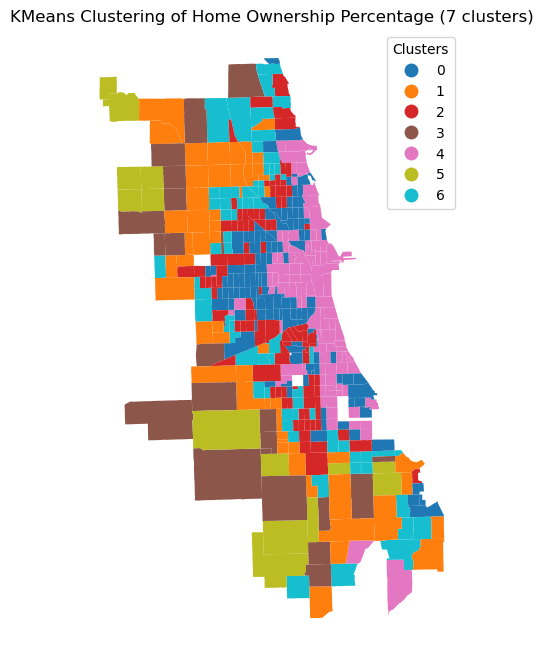

In [8]:
from sklearn.cluster import KMeans

# KMeans clustering on housing percent
kmeans = KMeans(n_clusters=7, random_state=42)
chicago['cluster'] = kmeans.fit_predict(chicago[['ho_pct']])

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
chicago.plot(column='cluster', categorical=True, legend=True, 
            legend_kwds={'title': 'Clusters'}, ax=ax)
plt.title('KMeans Clustering of Home Ownership Percentage (7 clusters)')
plt.axis('off')
plt.show()

## Q. Analyse the result

The clusters are disjoint.
Cluster 4 is distributed along the east coast. 
Cluster 1 is very disjoint



# Spatial Weights

C:\Users\bill\AppData\Local\Temp\ipykernel_27620\2611011761.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(chicago)
C:\Users\bill\OneDrive - IPN Valuers\Documents\GitHub\spatial-data-science-in-python-billjwilliamson\.pixi\envs\default\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


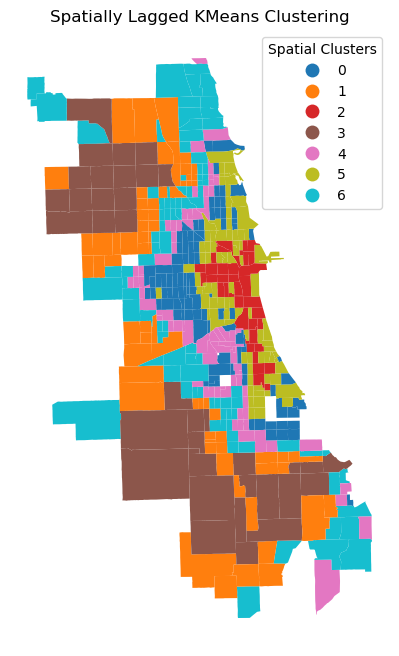

In [9]:
import libpysal
from libpysal.weights import Queen
import numpy as np

w = Queen.from_dataframe(chicago)

ho_pct_lag = libpysal.weights.lag_spatial(w, chicago['ho_pct'])

X = np.column_stack((chicago['ho_pct'], ho_pct_lag))

kmeans = KMeans(n_clusters=7, random_state=42)
chicago['spatial_cluster'] = kmeans.fit_predict(X)

fig, ax = plt.subplots(figsize=(12, 8))
chicago.plot(column='spatial_cluster', categorical=True, legend=True,
            legend_kwds={'title': 'Spatial Clusters'}, ax=ax)
plt.title('Spatially Lagged KMeans Clustering')
plt.axis('off')
plt.show()

# Q. Develop a regionalisation using agglomerative clustering

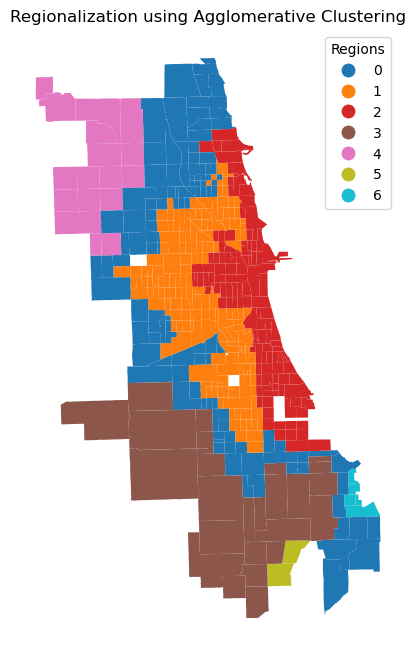

In [10]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# connectivity matrix 
connectivity = w.sparse.toarray()

# agglomerative clustering with spatial constraints
agg_cluster = AgglomerativeClustering(
    n_clusters=7,
    connectivity=connectivity,
    linkage='ward'
)


chicago['region'] = agg_cluster.fit_predict(chicago[['ho_pct']])

# Plot 
fig, ax = plt.subplots(figsize=(12, 8))
chicago.plot(column='region', categorical=True, legend=True,
            legend_kwds={'title': 'Regions'}, ax=ax)
plt.title('Regionalization using Agglomerative Clustering')
plt.axis('off')
plt.show()

In [11]:
print("Number of areas in each region:")
print(chicago['region'].value_counts().sort_index())

Number of areas in each region:
region
0    124
1    192
2    130
3     26
4     17
5      2
6      5
Name: count, dtype: int64


## Q. Dissolve the GeoDataFrame by region to get region boundaries

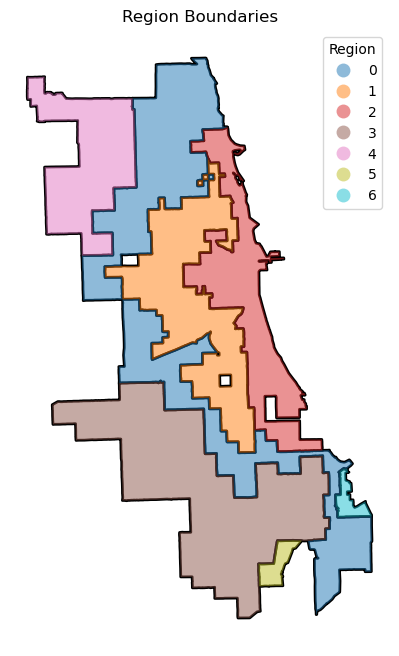

In [12]:

region_boundaries = chicago.dissolve(by='region')

fig, ax = plt.subplots(figsize=(12, 8))
region_boundaries.plot(edgecolor='black', facecolor='none', linewidth=2, ax=ax)
region_boundaries.plot(column=region_boundaries.index, categorical=True, 
                      legend=True, legend_kwds={'title': 'Region'}, 
                      alpha=0.5, ax=ax)
plt.title('Region Boundaries')
plt.axis('off')
plt.show()